In [105]:
# Import necessary libraries
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from kaggle.api.kaggle_api_extended import KaggleApi
import zipfile


In [84]:
# Set random seed for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

In [8]:
# --- Step 1: Download Dataset from Kaggle ---
!pip install kaggle
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d jlexzhong/mineral-microscopic-image-dataset

Dataset URL: https://www.kaggle.com/datasets/jlexzhong/mineral-microscopic-image-dataset
License(s): unknown
mineral-microscopic-image-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [9]:
import zipfile
with zipfile.ZipFile("/content/mineral-microscopic-image-dataset.zip", 'r') as zip_ref:
    zip_ref.extractall("mineral-microscopic-image-dataset")

In [112]:
# --- Step 2: Load and Translate Labels ---
# Define translation dictionary for Chinese mineral names to English
label_translation = {
    '十字石': 'Staurolite',
    '斜长石': 'Plagioclase',
    '普通辉石': 'Pyroxene',
    '橄榄石': 'Olivine',
    '石榴子石': 'Garnet',
    '红柱石': 'Andalusite',
    '角闪石': 'Hornblende',
    '鲕粒': 'Epidote'
}

# Hardcode the Chinese folder names to match the dataset structure
chinese_folders = [
    '十字石', '斜长石', '普通辉石', '橄榄石',
    '石榴子石', '红柱石', '角闪石', '鲕粒'
]

data = []
labels = []

# Dataset path
data_path = '/content/mineral-microscopic-image-dataset/scidb_data'
# Use scandir to safely iterate over directory contents
for entry in os.scandir(data_path):
    if entry.is_dir():
        try:
            # Attempt to decode the folder name as UTF-8
            folder_name = entry.name.encode().decode('utf-8')
            if folder_name in chinese_folders:
                translated = label_translation[folder_name]
                class_path = os.path.join(data_path, folder_name)
                for img_name in os.listdir(class_path):
                    img_path = os.path.join(class_path, img_name)
                    data.append(img_path)
                    labels.append(translated)
        except UnicodeDecodeError:
            continue  # Skip if decoding fails

# Create DataFrame
df = pd.DataFrame({'image_path': data, 'label': labels})
print("Dataset loaded. Number of images:", len(df))
print("Classes found:", df['label'].unique())

Dataset loaded. Number of images: 671
Classes found: ['Andalusite' 'Pyroxene' 'Olivine' 'Hornblende' 'Garnet' 'Plagioclase'
 'Staurolite' 'Epidote']


In [113]:
# --- Step 3: Preprocessing ---
le = LabelEncoder()
df['label_encoded'] = le.fit_transform(df['label'])

train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['label_encoded'], random_state=42)

train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)

img_size = (224, 224)  # MobileNetV2 default input size
batch_size = 16
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='image_path',
    y_col='label',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

val_generator = val_datagen.flow_from_dataframe(
    val_df,
    x_col='image_path',
    y_col='label',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 536 validated image filenames belonging to 8 classes.
Found 135 validated image filenames belonging to 8 classes.


In [114]:
# --- Step 4: Build Model with MobileNetV2 ---
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(*img_size, 3))
base_model.trainable = False  # Freeze base layers initially

num_classes = len(le.classes_)
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()

Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,984 (9.24 MB)

 Trainable params: 165,000 (644.53 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [115]:
# --- Step 5: Train Model (Initial Training with Frozen Base) ---
callbacks = [
    EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, min_lr=1e-6),
    ModelCheckpoint('best_model_mobilenetv2.h5', monitor='val_loss', save_best_only=True)
]

history = model.fit(
    train_generator,
    epochs=20,  # Initial training with frozen base
    validation_data=val_generator,
    callbacks=callbacks
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step - accuracy: 0.2089 - loss: 2.5544

34/34 ━━━━━━━━━━━━━━━━━━━━ 31s 706ms/step - accuracy: 0.2110 - loss: 2.5414 - val_accuracy: 0.6963 - val_loss: 1.1300 - learning_rate: 1.0000e-04
Epoch 2/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step - accuracy: 0.5470 - loss: 1.3275

34/34 ━━━━━━━━━━━━━━━━━━━━ 17s 515ms/step - accuracy: 0.5492 - loss: 1.3219 - val_accuracy: 0.8667 - val_loss: 0.6636 - learning_rate: 1.0000e-04
Epoch 3/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step - accuracy: 0.6955 - loss: 0.8181

34/34 ━━━━━━━━━━━━━━━━━━━━ 18s 523ms/step - accuracy: 0.6972 - loss: 0.8156 - val_accuracy: 0.9556 - val_loss: 0.4091 - learning_rate: 1.0000e-04
Epoch 4/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step - accuracy: 0.8305 - loss: 0.5702

34/34 ━━━━━━━━━━━━━━━━━━━━ 18s 533ms/step - accuracy: 0.8314 - loss: 0.5687 - val_accuracy: 0.9481 - val_loss: 0.2741 - learning_rate: 1.0000e-04
Epoch 5/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step - accuracy: 0.8834 - loss: 0.4515

34/34 ━━━━━━━━━━━━━━━━━━━━ 18s 541ms/step - accuracy: 0.8836 - loss: 0.4505 - val_accuracy: 0.9778 - val_loss: 0.1943 - learning_rate: 1.0000e-04
Epoch 6/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step - accuracy: 0.9190 - loss: 0.3760

34/34 ━━━━━━━━━━━━━━━━━━━━ 17s 511ms/step - accuracy: 0.9194 - loss: 0.3742 - val_accuracy: 0.9778 - val_loss: 0.1470 - learning_rate: 1.0000e-04
Epoch 7/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step - accuracy: 0.9586 - loss: 0.2436

34/34 ━━━━━━━━━━━━━━━━━━━━ 18s 538ms/step - accuracy: 0.9588 - loss: 0.2429 - val_accuracy: 0.9778 - val_loss: 0.1179 - learning_rate: 1.0000e-04
Epoch 8/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step - accuracy: 0.9727 - loss: 0.1863

34/34 ━━━━━━━━━━━━━━━━━━━━ 18s 539ms/step - accuracy: 0.9726 - loss: 0.1862 - val_accuracy: 0.9778 - val_loss: 0.0969 - learning_rate: 1.0000e-04
Epoch 9/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step - accuracy: 0.9663 - loss: 0.1951

34/34 ━━━━━━━━━━━━━━━━━━━━ 18s 542ms/step - accuracy: 0.9662 - loss: 0.1948 - val_accuracy: 0.9778 - val_loss: 0.0826 - learning_rate: 1.0000e-04
Epoch 10/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step - accuracy: 0.9736 - loss: 0.1489

34/34 ━━━━━━━━━━━━━━━━━━━━ 19s 551ms/step - accuracy: 0.9735 - loss: 0.1491 - val_accuracy: 1.0000 - val_loss: 0.0702 - learning_rate: 1.0000e-04
Epoch 11/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step - accuracy: 0.9849 - loss: 0.1176

34/34 ━━━━━━━━━━━━━━━━━━━━ 18s 545ms/step - accuracy: 0.9849 - loss: 0.1178 - val_accuracy: 1.0000 - val_loss: 0.0594 - learning_rate: 1.0000e-04
Epoch 12/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step - accuracy: 0.9653 - loss: 0.1358

34/34 ━━━━━━━━━━━━━━━━━━━━ 18s 520ms/step - accuracy: 0.9654 - loss: 0.1356 - val_accuracy: 0.9852 - val_loss: 0.0540 - learning_rate: 1.0000e-04
Epoch 13/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step - accuracy: 0.9848 - loss: 0.0956

34/34 ━━━━━━━━━━━━━━━━━━━━ 18s 536ms/step - accuracy: 0.9846 - loss: 0.0958 - val_accuracy: 0.9926 - val_loss: 0.0469 - learning_rate: 1.0000e-04
Epoch 14/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step - accuracy: 0.9916 - loss: 0.1031

34/34 ━━━━━━━━━━━━━━━━━━━━ 18s 533ms/step - accuracy: 0.9916 - loss: 0.1025 - val_accuracy: 0.9926 - val_loss: 0.0430 - learning_rate: 1.0000e-04
Epoch 15/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step - accuracy: 0.9903 - loss: 0.0716

34/34 ━━━━━━━━━━━━━━━━━━━━ 18s 529ms/step - accuracy: 0.9902 - loss: 0.0717 - val_accuracy: 0.9926 - val_loss: 0.0383 - learning_rate: 1.0000e-04
Epoch 16/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step - accuracy: 0.9870 - loss: 0.0743

34/34 ━━━━━━━━━━━━━━━━━━━━ 18s 519ms/step - accuracy: 0.9871 - loss: 0.0742 - val_accuracy: 0.9926 - val_loss: 0.0358 - learning_rate: 1.0000e-04
Epoch 17/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step - accuracy: 0.9950 - loss: 0.0603

34/34 ━━━━━━━━━━━━━━━━━━━━ 18s 522ms/step - accuracy: 0.9950 - loss: 0.0602 - val_accuracy: 0.9926 - val_loss: 0.0335 - learning_rate: 1.0000e-04
Epoch 18/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step - accuracy: 0.9766 - loss: 0.0804

34/34 ━━━━━━━━━━━━━━━━━━━━ 18s 545ms/step - accuracy: 0.9766 - loss: 0.0802 - val_accuracy: 0.9926 - val_loss: 0.0304 - learning_rate: 1.0000e-04
Epoch 19/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 17s 515ms/step - accuracy: 0.9929 - loss: 0.0462 - val_accuracy: 0.9926 - val_loss: 0.0318 - learning_rate: 1.0000e-04
Epoch 20/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step - accuracy: 0.9918 - loss: 0.0477

34/34 ━━━━━━━━━━━━━━━━━━━━ 18s 524ms/step - accuracy: 0.9918 - loss: 0.0477 - val_accuracy: 0.9926 - val_loss: 0.0269 - learning_rate: 1.0000e-04


In [116]:
# --- Step 6: Fine-Tune the Model ---
base_model.trainable = True
for layer in base_model.layers[:100]:  # Fine-tune later layers
    layer.trainable = False

model.compile(
    optimizer=Adam(learning_rate=0.00001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_fine = model.fit(
    train_generator,
    epochs=20,  # Fine-tuning epochs
    validation_data=val_generator,
    callbacks=callbacks
)

Epoch 1/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 694ms/step - accuracy: 0.7528 - loss: 0.7611

34/34 ━━━━━━━━━━━━━━━━━━━━ 56s 964ms/step - accuracy: 0.7535 - loss: 0.7590 - val_accuracy: 0.9926 - val_loss: 0.0242 - learning_rate: 1.0000e-05
Epoch 2/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 17s 509ms/step - accuracy: 0.8644 - loss: 0.5120 - val_accuracy: 0.9926 - val_loss: 0.0270 - learning_rate: 1.0000e-05
Epoch 3/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 17s 496ms/step - accuracy: 0.8917 - loss: 0.3775 - val_accuracy: 0.9926 - val_loss: 0.0290 - learning_rate: 1.0000e-05
Epoch 4/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 17s 515ms/step - accuracy: 0.9102 - loss: 0.3525 - val_accuracy: 0.9926 - val_loss: 0.0274 - learning_rate: 1.0000e-05
Epoch 5/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 17s 509ms/step - accuracy: 0.9386 - loss: 0.2459 - val_accuracy: 0.9926 - val_loss: 0.0263 - learning_rate: 3.0000e-06
Epoch 6/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 17s 513ms/step - accuracy: 0.9506 - loss: 0.2433 - val_accuracy: 0.9926 - val_loss: 0.0258 - learning_rate: 3.0000e-06
Epoch 7/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 18s 521ms/step - accuracy: 0.95

34/34 ━━━━━━━━━━━━━━━━━━━━ 17s 511ms/step - accuracy: 0.9551 - loss: 0.2376 - val_accuracy: 0.9926 - val_loss: 0.0240 - learning_rate: 1.0000e-06
Epoch 10/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step - accuracy: 0.9577 - loss: 0.2135

34/34 ━━━━━━━━━━━━━━━━━━━━ 18s 523ms/step - accuracy: 0.9579 - loss: 0.2131 - val_accuracy: 0.9926 - val_loss: 0.0234 - learning_rate: 1.0000e-06
Epoch 11/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step - accuracy: 0.9518 - loss: 0.2119

34/34 ━━━━━━━━━━━━━━━━━━━━ 18s 523ms/step - accuracy: 0.9519 - loss: 0.2119 - val_accuracy: 0.9926 - val_loss: 0.0233 - learning_rate: 1.0000e-06
Epoch 12/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step - accuracy: 0.9413 - loss: 0.2359

34/34 ━━━━━━━━━━━━━━━━━━━━ 18s 528ms/step - accuracy: 0.9415 - loss: 0.2358 - val_accuracy: 0.9926 - val_loss: 0.0232 - learning_rate: 1.0000e-06
Epoch 13/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step - accuracy: 0.9592 - loss: 0.2029

34/34 ━━━━━━━━━━━━━━━━━━━━ 18s 533ms/step - accuracy: 0.9591 - loss: 0.2032 - val_accuracy: 0.9926 - val_loss: 0.0229 - learning_rate: 1.0000e-06
Epoch 14/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 17s 511ms/step - accuracy: 0.9460 - loss: 0.2080 - val_accuracy: 0.9926 - val_loss: 0.0230 - learning_rate: 1.0000e-06
Epoch 15/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 18s 521ms/step - accuracy: 0.9457 - loss: 0.2272 - val_accuracy: 0.9926 - val_loss: 0.0230 - learning_rate: 1.0000e-06
Epoch 16/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 17s 507ms/step - accuracy: 0.9650 - loss: 0.2127 - val_accuracy: 0.9926 - val_loss: 0.0229 - learning_rate: 1.0000e-06
Epoch 17/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step - accuracy: 0.9709 - loss: 0.1895

34/34 ━━━━━━━━━━━━━━━━━━━━ 17s 513ms/step - accuracy: 0.9709 - loss: 0.1893 - val_accuracy: 0.9926 - val_loss: 0.0228 - learning_rate: 1.0000e-06
Epoch 18/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step - accuracy: 0.9737 - loss: 0.1602

34/34 ━━━━━━━━━━━━━━━━━━━━ 18s 546ms/step - accuracy: 0.9732 - loss: 0.1609 - val_accuracy: 0.9926 - val_loss: 0.0227 - learning_rate: 1.0000e-06
Epoch 19/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 17s 507ms/step - accuracy: 0.9697 - loss: 0.1763 - val_accuracy: 0.9926 - val_loss: 0.0228 - learning_rate: 1.0000e-06
Epoch 20/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step - accuracy: 0.9688 - loss: 0.1674

34/34 ━━━━━━━━━━━━━━━━━━━━ 18s 530ms/step - accuracy: 0.9686 - loss: 0.1676 - val_accuracy: 0.9926 - val_loss: 0.0226 - learning_rate: 1.0000e-06


9/9 ━━━━━━━━━━━━━━━━━━━━ 9s 684ms/step

Classification Report:
              precision    recall  f1-score   support

  Andalusite       1.00      1.00      1.00         8
     Epidote       1.00      1.00      1.00         9
      Garnet       1.00      1.00      1.00         5
  Hornblende       1.00      1.00      1.00        21
     Olivine       1.00      1.00      1.00        27
 Plagioclase       0.96      1.00      0.98        23
    Pyroxene       1.00      0.97      0.98        30
  Staurolite       1.00      1.00      1.00        12

    accuracy                           0.99       135
   macro avg       0.99      1.00      1.00       135
weighted avg       0.99      0.99      0.99       135



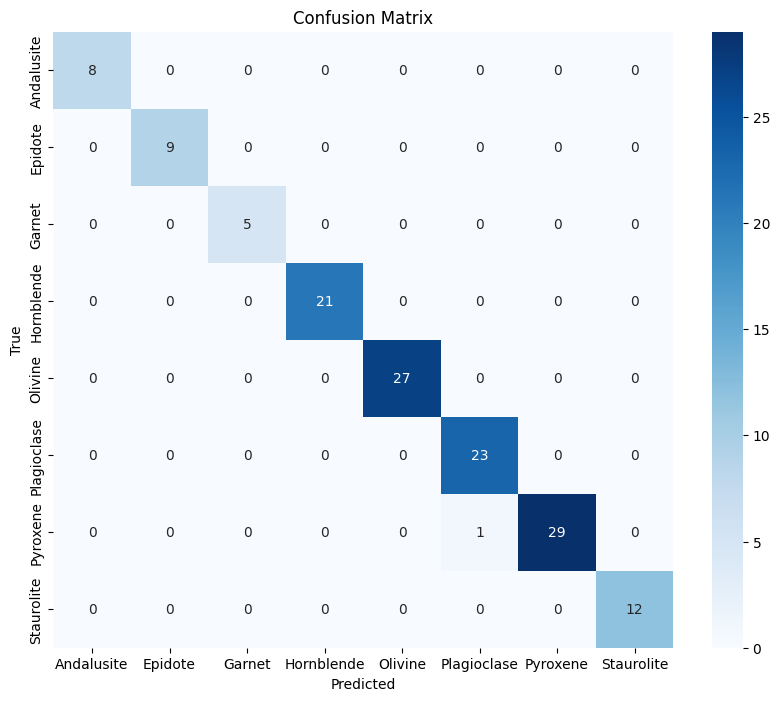

In [117]:
# --- Step 7: Evaluate Model ---
val_generator.reset()
y_pred = model.predict(val_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = le.transform(val_df['label'])

print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, target_names=le.classes_, zero_division=0))

cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

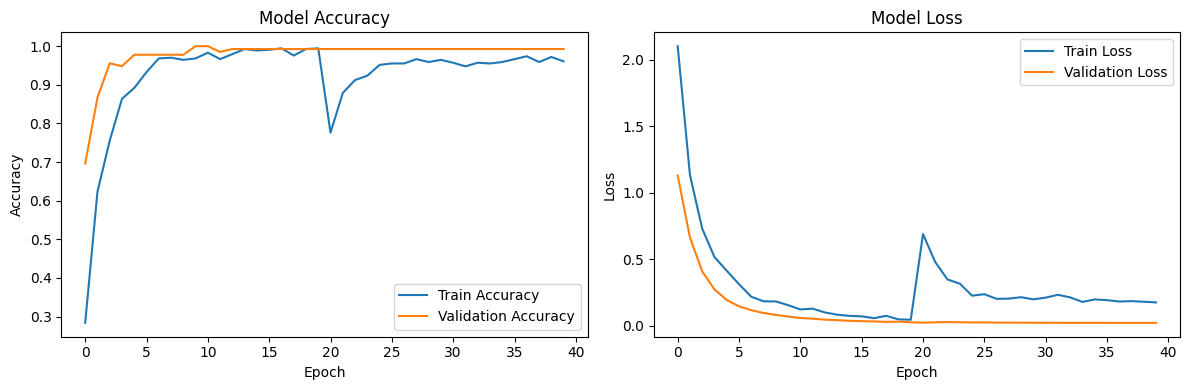

In [119]:
# --- Step 8: Plot Training History ---
acc = history.history['accuracy'] + history_fine.history['accuracy']
val_acc = history.history['val_accuracy'] + history_fine.history['val_accuracy']
loss = history.history['loss'] + history_fine.history['loss']
val_loss = history.history['val_loss'] + history_fine.history['val_loss']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.plot(acc, label='Train Accuracy')
ax1.plot(val_acc, label='Validation Accuracy')
ax1.set_title('Model Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()

ax2.plot(loss, label='Train Loss')
ax2.plot(val_loss, label='Validation Loss')
ax2.set_title('Model Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()

plt.tight_layout()
plt.show()